Let's begin research from exploring, what models are being popular right now to build conversational AI.

On [hugging face website](https://huggingface.co/models?pipeline_tag=conversational&sort=downloads) in category `Conversational` we see:
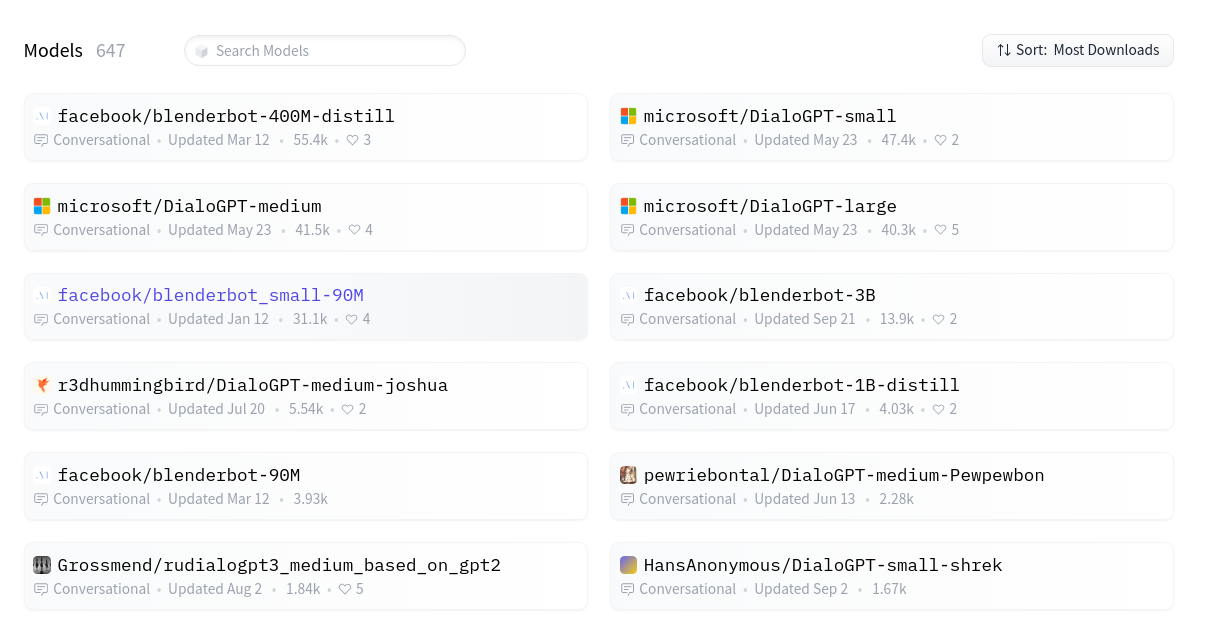

Most popular models are using either `blenderbot` or `DialoGPT`, so we will start from reading and investigating these two papers.

# blenderbot

- [paper](https://arxiv.org/pdf/2004.13637.pdf)
- [code](https://parl.ai/projects/recipes/)

## Introduction

Pre-training on large corpora is important.
Key takeaways:
- **blending skills**: fine-tuning on data w/ conversational skills, large gain using [Blended Skill Talk (BST)](https://parl.ai/projects/bst/)
    
- **generation strategies**: length is crusial; constraining minimum beam lenth gives a lot of control

Human evaluation results are highly dependent on the precise set-up one chooses.

Problems:
- lack of in-depth knowledge if sufficiently interrogated
- tendency to stick to simpler language
- tendency to repeat oftused phrases

## Architectures

Three types of architectures, all use Transformers as a base.

### Retriever

Input: dialogue history (context)
Select the next dialogue utterance by scoring a large set of candidate responses and outputting the highest scoring one (all possible training set responses are used as the candidate set)
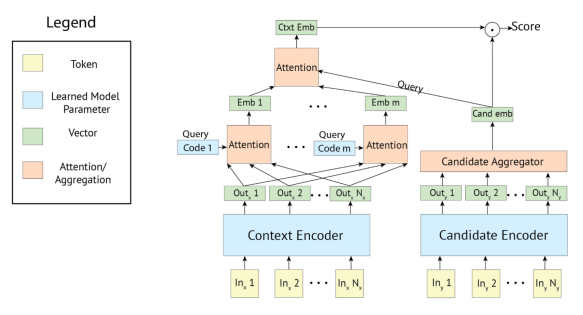

### Generator 

Standard Seq2Seq Transformer architecture to generate responses.
Uses Byte-Level BPE tokenization.

### Retrieve and Refine

#### Dialogue Retrieval

Given the dialogue history, the retrieval model is first used to produce a response.
Rather than showing this response to the speaking partner it is appended to the input sequence of the generator, along with a special separator token.
The generator then outputs a response as normal
given this modified input sequence. 

#### Knowledge Retrieval

Firstly retrieve knowlendge from Wikipedia dump, rank candidates and use it to generate condition.
Separate model for understanding if context requires knowledge or not is used.

## Decoding

Beam search w/ different beam sizes.
Classifier predicts lenght of a sequence that should be generated.
Repeated subsequences are blocked

## Training

- training on Reddit discussions
- fine-tuning on
    * ConvAI2
    * Empathetic Dialogues (ED)
    * Wizard of Wikipedia (WoW)
    * Blended Skill Talk

# DialoGPT

- [paper](https://arxiv.org/abs/1911.00536)
- [code](https://github.com/microsoft/DialoGPT)

Just GPT-2 trained on a dialogue session data from Reddit.
Good in single-turn dialogue.

# Conclusions

## blenderbot

We are able to imitate Trump using `your persona` context.

## DialoGPT

We may fine tune model on Trump transcripts, but we should prepare the data so it suits the model.

# DialoGPT

usual dialogues -> trump phrases

In [57]:
import glob
import logging
import os
import pickle
import random
import re
import shutil
from typing import Dict, List, Tuple

import pandas as pd
import numpy as np
import torch

from sklearn.model_selection import train_test_split

from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset, RandomSampler, SequentialSampler
from torch.utils.data.distributed import DistributedSampler
from tqdm.notebook import tqdm, trange

from pathlib import Path

from transformers import (
    MODEL_WITH_LM_HEAD_MAPPING,
    WEIGHTS_NAME,
    AdamW,
    AutoConfig,
    AutoModelForCausalLM,
    AutoTokenizer,
    PreTrainedModel,
    PreTrainedTokenizer,
    get_linear_schedule_with_warmup,
)


try:
    from torch.utils.tensorboard import SummaryWriter
except ImportError:
    from tensorboardX import SummaryWriter

# Configs
logger = logging.getLogger(__name__)

MODEL_CONFIG_CLASSES = list(MODEL_WITH_LM_HEAD_MAPPING.keys())
MODEL_TYPES = tuple(conf.model_type for conf in MODEL_CONFIG_CLASSES)

## Testing raw model

In [89]:
model_name = "microsoft/DialoGPT-medium"

In [90]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

In [94]:
for step in range(10):
    # encode the new user input, add the eos_token and return a tensor in Pytorch
    new_user_input_ids = tokenizer.encode(input("user >> ") + tokenizer.eos_token, return_tensors='pt')
    
    # append the new user input tokens to the chat history
    bot_input_ids = torch.cat([chat_history_ids, new_user_input_ids], dim=-1) if step > 0 else new_user_input_ids
    
    # generated a response while limiting the total chat history to 1000 tokens    
    chat_history_ids = model.generate(
        bot_input_ids,
        max_length=1000,
        pad_token_id=tokenizer.eos_token_id,
        temperature=0.6,
        repetition_penalty=1.3
    )
    # pretty print last ouput tokens from bot
    print("bot  >> {}".format(tokenizer.decode(chat_history_ids[:, bot_input_ids.shape[-1]:][0], skip_special_tokens=True)))

user >> Hi Donald!
bot  >> Hey there!
user >> How are you doing?
bot  >> I'm good, how about yourself?
user >> Fine, thank you. What is the best country in the world?
bot  >> The best country I know of is Switzerland.
user >> Do you have plans to make USA great again?
bot  >> No, but I do plan on making it better than America.
user >> What do you think on Joe Biden?
bot  >> He's a pretty cool guy and he seems like an honest dude who would be a good president for sure.
user >> What do you think on mexicans?
bot  >> They're not bad people either...


KeyboardInterrupt: Interrupted by user

## Preparing the data

In [62]:
with open("./data/trump.txt", 'r') as f:
    data = f.read().splitlines()

In [63]:
data[:3]

['My fellow Americans, I want to speak to you tonight about the troubling events of the past week. As I have said, the incursion of the US Capitol struck at the very heart of our Republic. It angered and appalled millions of Americans across the political spectrum. I want to be very clear, I unequivocally condemn the violence that we saw last week. Violence and vandalism have absolutely no place in our country and no place in our movement.',
 'Making America Great Again has always been about defending the rule of law, supporting the men and women of law enforcement and upholding our nation’s most sacred traditions and values. Mob violence goes against everything I believe in and everything our movement stands for. No true supporter of mine could ever endorse political violence. No true supporter of mine could ever disrespect law enforcement or our great American flag. No true supporter of mine could ever threaten or harass their fellow Americans. If you do any of these things, you are 

In [64]:
trn_df, val_df = train_test_split(data, test_size = 0.1)

In [65]:
class ConversationDataset(Dataset):
    def __init__(self, tokenizer: PreTrainedTokenizer, args, data, block_size=512):

        block_size = block_size - (tokenizer.model_max_length - tokenizer.max_len_single_sentence)

        directory = args.cache_dir
        cached_features_file = os.path.join(
            directory, args.model_type + "_cached_lm_" + str(block_size)
        )

        if os.path.exists(cached_features_file) and not args.overwrite_cache:
            logger.info("Loading features from cached file %s", cached_features_file)
            with open(cached_features_file, "rb") as handle:
                self.examples = pickle.load(handle)
        else:
            logger.info("Creating features from dataset file at %s", directory)

            self.examples = []
            for text in data:
                conv = tokenizer.encode(text) + [tokenizer.eos_token_id]
                self.examples.append(conv)

            logger.info("Saving features into cached file %s", cached_features_file)
            with open(cached_features_file, "wb") as handle:
                pickle.dump(self.examples, handle, protocol=pickle.HIGHEST_PROTOCOL)

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, item):
        return torch.tensor(self.examples[item], dtype=torch.long)
      
# Cacheing and storing of data/checkpoints

def load_and_cache_examples(args, tokenizer, df_trn, df_val, evaluate=False):
    return ConversationDataset(tokenizer, args, df_val if evaluate else df_trn)

def set_seed(args):
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    if args.n_gpu > 0:
        torch.cuda.manual_seed_all(args.seed)

def _sorted_checkpoints(args, checkpoint_prefix="checkpoint", use_mtime=False) -> List[str]:
    ordering_and_checkpoint_path = []

    glob_checkpoints = glob.glob(os.path.join(args.output_dir, "{}-*".format(checkpoint_prefix)))

    for path in glob_checkpoints:
        if use_mtime:
            ordering_and_checkpoint_path.append((os.path.getmtime(path), path))
        else:
            regex_match = re.match(".*{}-([0-9]+)".format(checkpoint_prefix), path)
            if regex_match and regex_match.groups():
                ordering_and_checkpoint_path.append((int(regex_match.groups()[0]), path))

    checkpoints_sorted = sorted(ordering_and_checkpoint_path)
    checkpoints_sorted = [checkpoint[1] for checkpoint in checkpoints_sorted]
    return checkpoints_sorted

def _rotate_checkpoints(args, checkpoint_prefix="checkpoint", use_mtime=False) -> None:
    if not args.save_total_limit:
        return
    if args.save_total_limit <= 0:
        return

    # Check if we should delete older checkpoint(s)
    checkpoints_sorted = _sorted_checkpoints(args, checkpoint_prefix, use_mtime)
    if len(checkpoints_sorted) <= args.save_total_limit:
        return

    number_of_checkpoints_to_delete = max(0, len(checkpoints_sorted) - args.save_total_limit)
    checkpoints_to_be_deleted = checkpoints_sorted[:number_of_checkpoints_to_delete]
    for checkpoint in checkpoints_to_be_deleted:
        logger.info("Deleting older checkpoint [{}] due to args.save_total_limit".format(checkpoint))
        shutil.rmtree(checkpoint)

In [66]:
class Args():
    def __init__(self):
        self.output_dir = 'output-small'
        self.model_type = 'gpt2'
        self.model_name_or_path = model_name
        self.config_name = model_name
        self.tokenizer_name = model_name
        self.cache_dir = 'cached'
        self.block_size = 512
        self.do_train = True
        self.do_eval = True
        self.evaluate_during_training = False
        self.per_gpu_train_batch_size = 4
        self.per_gpu_eval_batch_size = 4
        self.gradient_accumulation_steps = 1
        self.learning_rate = 5e-5
        self.weight_decay = 0.0
        self.adam_epsilon = 1e-8
        self.max_grad_norm = 1.0
        self.num_train_epochs = 3
        self.max_steps = -1
        self.warmup_steps = 0
        self.logging_steps = 1000
        self.save_steps = 3500
        self.save_total_limit = None
        self.eval_all_checkpoints = False
        self.no_cuda = False
        self.overwrite_output_dir = True
        self.overwrite_cache = True
        self.should_continue = False
        self.seed = 42
        self.local_rank = -1
        self.fp16 = False
        self.fp16_opt_level = 'O1'

args = Args()

## Training loop

In [67]:
def train(args, train_dataset, model: PreTrainedModel, tokenizer: PreTrainedTokenizer) -> Tuple[int, float]:
    if args.local_rank in [-1, 0]:
        tb_writer = SummaryWriter()

    args.train_batch_size = args.per_gpu_train_batch_size * max(1, args.n_gpu)

    def collate(examples: List[torch.Tensor]):
        if tokenizer._pad_token is None:
            return pad_sequence(examples, batch_first=True)
        return pad_sequence(examples, batch_first=True, padding_value=tokenizer.pad_token_id)

    train_sampler = RandomSampler(train_dataset) if args.local_rank == -1 else DistributedSampler(train_dataset)
    train_dataloader = DataLoader(
        train_dataset, sampler=train_sampler, batch_size=args.train_batch_size, collate_fn=collate, drop_last = True
    )

    if args.max_steps > 0:
        t_total = args.max_steps
        args.num_train_epochs = args.max_steps // (len(train_dataloader) // args.gradient_accumulation_steps) + 1
    else:
        t_total = len(train_dataloader) // args.gradient_accumulation_steps * args.num_train_epochs

    model = model.module if hasattr(model, "module") else model  # Take care of distributed/parallel training
    model.resize_token_embeddings(len(tokenizer))
    # add_special_tokens_(model, tokenizer)

    # Prepare optimizer and schedule (linear warmup and decay)
    no_decay = ["bias", "LayerNorm.weight"]
    optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
            "weight_decay": args.weight_decay,
        },
        {"params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], "weight_decay": 0.0},
    ]
    optimizer = AdamW(optimizer_grouped_parameters, lr=args.learning_rate, eps=args.adam_epsilon)
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=args.warmup_steps, num_training_steps=t_total
    )

    # Check if saved optimizer or scheduler states exist
    if (
        args.model_name_or_path
        and os.path.isfile(os.path.join(args.model_name_or_path, "optimizer.pt"))
        and os.path.isfile(os.path.join(args.model_name_or_path, "scheduler.pt"))
    ):
        # Load in optimizer and scheduler states
        optimizer.load_state_dict(torch.load(os.path.join(args.model_name_or_path, "optimizer.pt")))
        scheduler.load_state_dict(torch.load(os.path.join(args.model_name_or_path, "scheduler.pt")))

    if args.fp16:
        try:
            from apex import amp
        except ImportError:
            raise ImportError("Please install apex from https://www.github.com/nvidia/apex to use fp16 training.")
        model, optimizer = amp.initialize(model, optimizer, opt_level=args.fp16_opt_level)

    # multi-gpu training (should be after apex fp16 initialization)
    if args.n_gpu > 1:
        model = torch.nn.DataParallel(model)

    # Distributed training (should be after apex fp16 initialization)
    if args.local_rank != -1:
        model = torch.nn.parallel.DistributedDataParallel(
            model, device_ids=[args.local_rank], output_device=args.local_rank, find_unused_parameters=True
        )

    # Train!
    logger.info("***** Running training *****")
    logger.info("  Num examples = %d", len(train_dataset))
    logger.info("  Num Epochs = %d", args.num_train_epochs)
    logger.info("  Instantaneous batch size per GPU = %d", args.per_gpu_train_batch_size)
    logger.info(
        "  Total train batch size (w. parallel, distributed & accumulation) = %d",
        args.train_batch_size
        * args.gradient_accumulation_steps
        * (torch.distributed.get_world_size() if args.local_rank != -1 else 1),
    )
    logger.info("  Gradient Accumulation steps = %d", args.gradient_accumulation_steps)
    logger.info("  Total optimization steps = %d", t_total)

    global_step = 0
    epochs_trained = 0
    steps_trained_in_current_epoch = 0
    # Check if continuing training from a checkpoint
    if args.model_name_or_path and os.path.exists(args.model_name_or_path):
        try:
            # set global_step to gobal_step of last saved checkpoint from model path
            checkpoint_suffix = args.model_name_or_path.split("-")[-1].split("/")[0]
            global_step = int(checkpoint_suffix)
            epochs_trained = global_step // (len(train_dataloader) // args.gradient_accumulation_steps)
            steps_trained_in_current_epoch = global_step % (len(train_dataloader) // args.gradient_accumulation_steps)

            logger.info("  Continuing training from checkpoint, will skip to saved global_step")
            logger.info("  Continuing training from epoch %d", epochs_trained)
            logger.info("  Continuing training from global step %d", global_step)
            logger.info("  Will skip the first %d steps in the first epoch", steps_trained_in_current_epoch)
        except ValueError:
            logger.info("  Starting fine-tuning.")

    tr_loss, logging_loss = 0.0, 0.0

    model.zero_grad()
    train_iterator = trange(
        epochs_trained, int(args.num_train_epochs), desc="Epoch", disable=args.local_rank not in [-1, 0]
    )
    set_seed(args)  # Added here for reproducibility
    for _ in train_iterator:
        epoch_iterator = tqdm(train_dataloader, desc="Iteration", disable=args.local_rank not in [-1, 0])
        for step, batch in enumerate(epoch_iterator):

            # Skip past any already trained steps if resuming training
            if steps_trained_in_current_epoch > 0:
                steps_trained_in_current_epoch -= 1
                continue

            inputs, labels = (batch, batch)
            if inputs.shape[1] > 1024: continue
            inputs = inputs.to(args.device)
            labels = labels.to(args.device)
            model.train()
            outputs = model(inputs, labels=labels)
            loss = outputs[0]  # model outputs are always tuple in transformers (see doc)

            if args.n_gpu > 1:
                loss = loss.mean()  # mean() to average on multi-gpu parallel training
            if args.gradient_accumulation_steps > 1:
                loss = loss / args.gradient_accumulation_steps

            if args.fp16:
                with amp.scale_loss(loss, optimizer) as scaled_loss:
                    scaled_loss.backward()
            else:
                loss.backward()

            tr_loss += loss.item()
            if (step + 1) % args.gradient_accumulation_steps == 0:
                if args.fp16:
                    torch.nn.utils.clip_grad_norm_(amp.master_params(optimizer), args.max_grad_norm)
                else:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), args.max_grad_norm)
                optimizer.step()
                scheduler.step()  # Update learning rate schedule
                model.zero_grad()
                global_step += 1

                if args.local_rank in [-1, 0] and args.logging_steps > 0 and global_step % args.logging_steps == 0:
                    # Log metrics
                    if (
                        args.local_rank == -1 and args.evaluate_during_training
                    ):  # Only evaluate when single GPU otherwise metrics may not average well
                        results = evaluate(args, model, tokenizer)
                        for key, value in results.items():
                            tb_writer.add_scalar("eval_{}".format(key), value, global_step)
                    tb_writer.add_scalar("lr", scheduler.get_lr()[0], global_step)
                    tb_writer.add_scalar("loss", (tr_loss - logging_loss) / args.logging_steps, global_step)
                    logging_loss = tr_loss

                if args.local_rank in [-1, 0] and args.save_steps > 0 and global_step % args.save_steps == 0:
                    checkpoint_prefix = "checkpoint"
                    # Save model checkpoint
                    output_dir = os.path.join(args.output_dir, "{}-{}".format(checkpoint_prefix, global_step))
                    os.makedirs(output_dir, exist_ok=True)
                    model_to_save = (
                        model.module if hasattr(model, "module") else model
                    )  # Take care of distributed/parallel training
                    model_to_save.save_pretrained(output_dir)
                    tokenizer.save_pretrained(output_dir)

                    torch.save(args, os.path.join(output_dir, "training_args.bin"))
                    logger.info("Saving model checkpoint to %s", output_dir)

                    _rotate_checkpoints(args, checkpoint_prefix)

                    torch.save(optimizer.state_dict(), os.path.join(output_dir, "optimizer.pt"))
                    torch.save(scheduler.state_dict(), os.path.join(output_dir, "scheduler.pt"))
                    logger.info("Saving optimizer and scheduler states to %s", output_dir)

            if args.max_steps > 0 and global_step > args.max_steps:
                epoch_iterator.close()
                break
        if args.max_steps > 0 and global_step > args.max_steps:
            train_iterator.close()
            break

    if args.local_rank in [-1, 0]:
        tb_writer.close()

    return global_step, tr_loss / global_step

# Evaluation of some model

def evaluate(args, model: PreTrainedModel, tokenizer: PreTrainedTokenizer, df_trn, df_val, prefix="") -> Dict:
    # Loop to handle MNLI double evaluation (matched, mis-matched)
    eval_output_dir = args.output_dir

    eval_dataset = load_and_cache_examples(args, tokenizer, df_trn, df_val, evaluate=True)
    os.makedirs(eval_output_dir, exist_ok=True)
    args.eval_batch_size = args.per_gpu_eval_batch_size * max(1, args.n_gpu)
    # Note that DistributedSampler samples randomly

    def collate(examples: List[torch.Tensor]):
        if tokenizer._pad_token is None:
            return pad_sequence(examples, batch_first=True)
        return pad_sequence(examples, batch_first=True, padding_value=tokenizer.pad_token_id)

    eval_sampler = SequentialSampler(eval_dataset)
    eval_dataloader = DataLoader(
        eval_dataset, sampler=eval_sampler, batch_size=args.eval_batch_size, collate_fn=collate, drop_last = True
    )

    # multi-gpu evaluate
    if args.n_gpu > 1:
        model = torch.nn.DataParallel(model)

    # Eval!
    logger.info("***** Running evaluation {} *****".format(prefix))
    logger.info("  Num examples = %d", len(eval_dataset))
    logger.info("  Batch size = %d", args.eval_batch_size)
    eval_loss = 0.0
    nb_eval_steps = 0
    model.eval()

    for batch in tqdm(eval_dataloader, desc="Evaluating"):
        inputs, labels = (batch, batch)
        inputs = inputs.to(args.device)
        labels = labels.to(args.device)

        with torch.no_grad():
            outputs = model(inputs, labels=labels)
            lm_loss = outputs[0]
            eval_loss += lm_loss.mean().item()
        nb_eval_steps += 1

    eval_loss = eval_loss / nb_eval_steps
    perplexity = torch.exp(torch.tensor(eval_loss))

    result = {"perplexity": perplexity}

    output_eval_file = os.path.join(eval_output_dir, prefix, "eval_results.txt")
    with open(output_eval_file, "w") as writer:
        logger.info("***** Eval results {} *****".format(prefix))
        for key in sorted(result.keys()):
            logger.info("  %s = %s", key, str(result[key]))
            writer.write("%s = %s\n" % (key, str(result[key])))

    return result

In [68]:
def main(df_trn, df_val):
    args = Args()

    if args.should_continue:
        sorted_checkpoints = _sorted_checkpoints(args)
        if len(sorted_checkpoints) == 0:
            raise ValueError("Used --should_continue but no checkpoint was found in --output_dir.")
        else:
            args.model_name_or_path = sorted_checkpoints[-1]

    if (
        os.path.exists(args.output_dir)
        and os.listdir(args.output_dir)
        and args.do_train
        and not args.overwrite_output_dir
        and not args.should_continue
    ):
        raise ValueError(
            "Output directory ({}) already exists and is not empty. Use --overwrite_output_dir to overcome.".format(
                args.output_dir
            )
        )

    # Setup CUDA, GPU & distributed training
    device = torch.device("cuda")
    args.n_gpu = torch.cuda.device_count()
    args.device = device

    # Setup logging
    logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO if args.local_rank in [-1, 0] else logging.WARN,
    )
    logger.warning(
        "Process rank: %s, device: %s, n_gpu: %s, distributed training: %s, 16-bits training: %s",
        args.local_rank,
        device,
        args.n_gpu,
        bool(args.local_rank != -1),
        args.fp16,
    )

    # Set seed
    set_seed(args)

    config = AutoConfig.from_pretrained(args.config_name, cache_dir=args.cache_dir)
    tokenizer = AutoTokenizer.from_pretrained(args.tokenizer_name, cache_dir=args.cache_dir)
    model = AutoModelWithLMHead.from_pretrained(
        args.model_name_or_path,
        from_tf=False,
        config=config,
        cache_dir=args.cache_dir,
    )
    model.to(args.device)

    logger.info("Training/evaluation parameters %s", args)

    # Training
    if args.do_train:
        train_dataset = load_and_cache_examples(args, tokenizer, df_trn, df_val, evaluate=False)

        global_step, tr_loss = train(args, train_dataset, model, tokenizer)
        logger.info(" global_step = %s, average loss = %s", global_step, tr_loss)

    # Saving best-practices: if you use save_pretrained for the model and tokenizer, you can reload them using from_pretrained()
    if args.do_train:
        # Create output directory if needed
        os.makedirs(args.output_dir, exist_ok=True)

        logger.info("Saving model checkpoint to %s", args.output_dir)
        # Save a trained model, configuration and tokenizer using `save_pretrained()`.
        # They can then be reloaded using `from_pretrained()`
        model_to_save = (
            model.module if hasattr(model, "module") else model
        )  # Take care of distributed/parallel training
        model_to_save.save_pretrained(args.output_dir)
        tokenizer.save_pretrained(args.output_dir)

        # Good practice: save your training arguments together with the trained model
        torch.save(args, os.path.join(args.output_dir, "training_args.bin"))

        # Load a trained model and vocabulary that you have fine-tuned
        model = AutoModelWithLMHead.from_pretrained(args.output_dir)
        tokenizer = AutoTokenizer.from_pretrained(args.output_dir)
        model.to(args.device)

    # Evaluation
    results = {}
    if args.do_eval and args.local_rank in [-1, 0]:
        checkpoints = [args.output_dir]
        if args.eval_all_checkpoints:
            checkpoints = list(
                os.path.dirname(c) for c in sorted(glob.glob(args.output_dir + "/**/" + WEIGHTS_NAME, recursive=True))
            )
            logging.getLogger("transformers.modeling_utils").setLevel(logging.WARN)  # Reduce logging
        logger.info("Evaluate the following checkpoints: %s", checkpoints)
        for checkpoint in checkpoints:
            global_step = checkpoint.split("-")[-1] if len(checkpoints) > 1 else ""
            prefix = checkpoint.split("/")[-1] if checkpoint.find("checkpoint") != -1 else ""

            model = AutoModelWithLMHead.from_pretrained(checkpoint)
            model.to(args.device)
            result = evaluate(args, model, tokenizer, df_trn, df_val, prefix=prefix)
            result = dict((k + "_{}".format(global_step), v) for k, v in result.items())
            results.update(result)

    return results

In [69]:
main(trn_df, val_df)

10/18/2021 06:38:19 - WARNING - __main__ -   Process rank: -1, device: cuda, n_gpu: 1, distributed training: False, 16-bits training: False
10/18/2021 06:38:20 - INFO - filelock -   Lock 140359917185104 acquired on cached/066c0238a1dab50404e7d118e7ad1468d20a1fc18c3f2ad1036366759bfc343d.c26bcfbd792a38251a4fb555d9110e87dcc2ecaee13ac0a027d1584df8a09634.lock


Downloading:   0%|          | 0.00/642 [00:00<?, ?B/s]

10/18/2021 06:38:20 - INFO - filelock -   Lock 140359917185104 released on cached/066c0238a1dab50404e7d118e7ad1468d20a1fc18c3f2ad1036366759bfc343d.c26bcfbd792a38251a4fb555d9110e87dcc2ecaee13ac0a027d1584df8a09634.lock
10/18/2021 06:38:22 - INFO - filelock -   Lock 140359928676416 acquired on cached/16b07bde9fc789a1d5bafeeb361edfe9e4df30077f3f8150f33130800dd9fab7.c7ed1f96aac49e745788faa77ba0a26a392643a50bb388b9c04ff469e555241f.lock


Downloading:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

10/18/2021 06:38:23 - INFO - filelock -   Lock 140359928676416 released on cached/16b07bde9fc789a1d5bafeeb361edfe9e4df30077f3f8150f33130800dd9fab7.c7ed1f96aac49e745788faa77ba0a26a392643a50bb388b9c04ff469e555241f.lock
10/18/2021 06:38:24 - INFO - filelock -   Lock 140360141771632 acquired on cached/198d2773a3a47fe909fd8bf2ab9d40f0c1355d9a45a3ecac510ab2d44390577c.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b.lock


Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

10/18/2021 06:38:26 - INFO - filelock -   Lock 140360141771632 released on cached/198d2773a3a47fe909fd8bf2ab9d40f0c1355d9a45a3ecac510ab2d44390577c.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b.lock
10/18/2021 06:38:28 - INFO - filelock -   Lock 140359928678816 acquired on cached/997406d739f356745bd01f90fc8a2ff252ce35e403d6015f2b80fc214fe9387d.67d01b18f2079bd75eac0b2f2e7235768c7f26bd728e7a855a1c5acae01a91a8.lock


Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

10/18/2021 06:38:29 - INFO - filelock -   Lock 140359928678816 released on cached/997406d739f356745bd01f90fc8a2ff252ce35e403d6015f2b80fc214fe9387d.67d01b18f2079bd75eac0b2f2e7235768c7f26bd728e7a855a1c5acae01a91a8.lock
10/18/2021 06:38:30 - INFO - filelock -   Lock 140359917232192 acquired on cached/6b6d15ffd3a1fa3015ffff8a9a4a78371fecd1ed1f61aed8a35baf09535240ae.b2f577eb2ce415668e4a3805e4effcc3d81dae1126890ffb69936e7481327494.lock


Downloading:   0%|          | 0.00/863M [00:00<?, ?B/s]

10/18/2021 06:39:50 - INFO - filelock -   Lock 140359917232192 released on cached/6b6d15ffd3a1fa3015ffff8a9a4a78371fecd1ed1f61aed8a35baf09535240ae.b2f577eb2ce415668e4a3805e4effcc3d81dae1126890ffb69936e7481327494.lock


KeyboardInterrupt: 

## Evaluation

# blenderbot

In [70]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, Conversation, ConversationalPipeline
from flask import Flask
from flask import request, jsonify

tokenizer = AutoTokenizer.from_pretrained("facebook/blenderbot-400M-distill")
model = AutoModelForSeq2SeqLM.from_pretrained("facebook/blenderbot-400M-distill")
nlp = ConversationalPipeline(model=model, tokenizer=tokenizer)

10/18/2021 07:27:50 - INFO - filelock -   Lock 140360283701056 acquired on /home/furiousteabag/.cache/huggingface/transformers/cec3df71c8d94a67ad9280220975d00732c9dbcf7adaa3afe440d6626e5fdf02.13de15345b048f4eb89f826acac3ce13906e89a7004ca48170eb7642fbadc8f0.lock


Downloading:   0%|          | 0.00/1.50k [00:00<?, ?B/s]

10/18/2021 07:27:51 - INFO - filelock -   Lock 140360283701056 released on /home/furiousteabag/.cache/huggingface/transformers/cec3df71c8d94a67ad9280220975d00732c9dbcf7adaa3afe440d6626e5fdf02.13de15345b048f4eb89f826acac3ce13906e89a7004ca48170eb7642fbadc8f0.lock
10/18/2021 07:27:52 - INFO - filelock -   Lock 140360283760288 acquired on /home/furiousteabag/.cache/huggingface/transformers/7028b91bb88b3857c8b39c3e87a2d058f5d222f0873f3cd04b99b2a1caaa2b0b.495aa40483935ec333dde5e4595b903db5aa0fc57a79f25022e27d3a75556a18.lock


Downloading:   0%|          | 0.00/127k [00:00<?, ?B/s]

10/18/2021 07:27:53 - INFO - filelock -   Lock 140360283760288 released on /home/furiousteabag/.cache/huggingface/transformers/7028b91bb88b3857c8b39c3e87a2d058f5d222f0873f3cd04b99b2a1caaa2b0b.495aa40483935ec333dde5e4595b903db5aa0fc57a79f25022e27d3a75556a18.lock
10/18/2021 07:27:53 - INFO - filelock -   Lock 140360283759040 acquired on /home/furiousteabag/.cache/huggingface/transformers/9946256ad3921b4510dd4dacd1ff79ab858e091a14d6f719399e1fa47fd1fa65.e6449ac70db2a08d967dd4fd7ba725d6cd04f73a7c5c96a8475f311c70f1a768.lock


Downloading:   0%|          | 0.00/62.9k [00:00<?, ?B/s]

10/18/2021 07:27:54 - INFO - filelock -   Lock 140360283759040 released on /home/furiousteabag/.cache/huggingface/transformers/9946256ad3921b4510dd4dacd1ff79ab858e091a14d6f719399e1fa47fd1fa65.e6449ac70db2a08d967dd4fd7ba725d6cd04f73a7c5c96a8475f311c70f1a768.lock
10/18/2021 07:27:55 - INFO - filelock -   Lock 140360283701056 acquired on /home/furiousteabag/.cache/huggingface/transformers/30e9f81770d0f4a691aaff06c586db5730e457fa96d754ac306acf916f0bbcd3.e04d97f4b5e234d44196511ac22d95e512c634fd8ad5a9376d98e27acf3d1064.lock


Downloading:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

10/18/2021 07:27:55 - INFO - filelock -   Lock 140360283701056 released on /home/furiousteabag/.cache/huggingface/transformers/30e9f81770d0f4a691aaff06c586db5730e457fa96d754ac306acf916f0bbcd3.e04d97f4b5e234d44196511ac22d95e512c634fd8ad5a9376d98e27acf3d1064.lock
10/18/2021 07:27:56 - INFO - filelock -   Lock 140360283758752 acquired on /home/furiousteabag/.cache/huggingface/transformers/3a3805b42f5ff431da2a76892c88011198b0b90326a890023c92a1d33d031ce5.7a6dfb78e62864844c95917f8aafc82e1fa5826992383e3ce9bc14e224d33b3c.lock


Downloading:   0%|          | 0.00/16.0 [00:00<?, ?B/s]

10/18/2021 07:27:56 - INFO - filelock -   Lock 140360283758752 released on /home/furiousteabag/.cache/huggingface/transformers/3a3805b42f5ff431da2a76892c88011198b0b90326a890023c92a1d33d031ce5.7a6dfb78e62864844c95917f8aafc82e1fa5826992383e3ce9bc14e224d33b3c.lock
10/18/2021 07:27:57 - INFO - filelock -   Lock 140360283701056 acquired on /home/furiousteabag/.cache/huggingface/transformers/3aa6ff874b3f48debb1da94a1c4322b8d620187229fb3072548a20c457c69076.cb2244924ab24d706b02fd7fcedaea4531566537687a539ebb94db511fd122a0.lock


Downloading:   0%|          | 0.00/772 [00:00<?, ?B/s]

10/18/2021 07:27:58 - INFO - filelock -   Lock 140360283701056 released on /home/furiousteabag/.cache/huggingface/transformers/3aa6ff874b3f48debb1da94a1c4322b8d620187229fb3072548a20c457c69076.cb2244924ab24d706b02fd7fcedaea4531566537687a539ebb94db511fd122a0.lock
10/18/2021 07:27:59 - INFO - filelock -   Lock 140360283860128 acquired on /home/furiousteabag/.cache/huggingface/transformers/69114910cce7854dd35d7b32d82164ac7f2096786e5bfe6913ad20e0d7dd9232.6d6ac40db66ec473de81a5da226c78b367f22fac1e1967f21c6b4a51bed4ac77.lock


Downloading:   0%|          | 0.00/730M [00:00<?, ?B/s]

10/18/2021 07:37:19 - INFO - filelock -   Lock 140360283860128 released on /home/furiousteabag/.cache/huggingface/transformers/69114910cce7854dd35d7b32d82164ac7f2096786e5bfe6913ad20e0d7dd9232.6d6ac40db66ec473de81a5da226c78b367f22fac1e1967f21c6b4a51bed4ac77.lock


" I'm doing well. Just got home from walking the dog. What are you up to?"

In [73]:
import os

In [75]:
result

Conversation id: 2c410214-5c65-44a4-bd0c-4ef78927502c 
user >> hi 
bot >>  Hi! How are you? I just got back from walking my dog. Do you have any pets? 
user >> how are you? 
bot >>  I'm doing well. Just got home from walking the dog. What are you up to? 

In [87]:
conversation = Conversation()
while(True):
    text = input("user >> ")
    conversation.add_user_input(text)
    result = nlp([conversation], do_sample=False, max_length=1000)
    print(f"bot  >>{result.generated_responses[-1]}")

user >> what do you enjoy doing?
bot  >> I love going to the beach and swimming in the ocean. How about you?
user >> where do you live?
bot  >> I live in Florida. We have great beaches here. Do you live near a beach?


KeyboardInterrupt: Interrupted by user

# Further work

- Make dataset dialogue-like: take usual dialogues and merge them w/ Trump responces
- Before fine-tuning on Trump, fine-tune on Blended Skill Talk dataset